## Jean-Eudes Rouffiac  

&nbsp;

&nbsp;

# <center>  Méthodes de clustering </center>  
  
**Objectifs** : 
   * mise en oeuvre des méthodes de clustering
   * visualisation des clusters obtenus
   * étude des caractéristiques des différents algos

&nbsp;

Les lignes de code suivantes permette d'importer les packages qui vont nous servir dans ce TP ainsi que des fonctions prédéfinies qui vont être utiles pour charger des données du data set Toy ou bien pour afficher un dendrogramme.

In [4]:
from scipy.cluster.hierarchy import dendrogram
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
%matplotlib inline

In [5]:
def load_dat(filename):
    mydata = pd.read_csv(filename, sep=' ', names=['x', 'y'], header=None)
    return mydata

In [46]:
def plot_points_classe_2d(X, Y, titre=' '):
    # setup marker generator and color map
    markers = ('o', '^', 's', 'x', 'v', 'h')
    colors = ('red', 'green', 'blue', 'gray', 'cyan', 'lightgreen', "cyan", "magenta", "black")
    cmap = ListedColormap(colors[:len(np.unique(Y))])
    #plt.figure()
    for idx, cl in enumerate(np.unique(Y)):
        plt.scatter(X[Y == cl, 0], X[Y == cl, 1], alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label='classe {}'.format(cl))
    #plt.show()
    plt.title(titre)
    plt.legend(loc='best')

In [7]:
def plot_dendogram(model, label_points=None):
    plt.style.use('ggplot')
    dendro = []
    for a, b in model.children_:
        dendro.append([a, b, float(len(dendro)+1), len(dendro)+1])
        # le dernier coefficient devrait contenir le nombre de feuilles
        # dependant de ce noeud  et non le dernier indice
        # de même, le niveau (3eme colonne) ne devrait pas etre
        # le nombre de noeud  mais la distance de Ward
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    dendrogram(dendro, color_threshold=1, labels=label_points,
               show_leaf_counts=True, ax=ax, orientation="right")

In [8]:
def generate_toy_datasets():
    n_points = 20 #nombre de points par classe
    X_toy, y_toy = make_blobs(n_samples=n_points,centers=3)

    #Génération des jeux de données

    # 3 clusters
    n_samples = 1500
    random_state = 170
    X, y = make_blobs(n_samples=n_samples, random_state=random_state)

    #Anisotropic
    transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
    X_aniso = np.dot(X, transformation)
    X_aniso=np.vstack([X_aniso[y==0], X_aniso[y==1]])
    y_aniso=np.hstack([y[y==0], y[y==1]])
    # Unequal Variance
    X_varied, y_varied = make_blobs(n_samples=n_samples,
                                    cluster_std=[1.0, 2.5, 0.5],
                                    random_state=random_state)
    # Different sizes
    X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))
    y_filtered = np.hstack([y[y == 0][:500],  y[y == 1][:100], y[y==2][:10]])

    return X_toy, y_toy, X, y, X_aniso, y_aniso, X_varied, y_varied, X_filtered, y_filtered

&nbsp;

## 1. Création des données  
  
Génération de 5 datasets : 
* X_toy composé d'un faible nombre de points
* X composé de 1500 points répartis en 3 classes
* X_aniso composé de deux classes répartis selon un axe préférentiel
* X_varied composé de 1500 points répartis dans l'espace en 3 classes, mais chaque classe ayant une variance différente.
* X_sized composé de 3 classes, mais dont les nombres d'éléments de chaque classe est désiquilibré : 500 pour la classe 1, 100 pour la classe 2, et 10 pour la classe 3.  
  
  

In [94]:
[X_toy, y_toy, X, y, X_aniso, y_aniso, X_varied, y_varied, X_filtered, y_filtered] = generate_toy_datasets()

  
    
   
     
       
         
           
           
<center> **Affichage des différents datasets.**

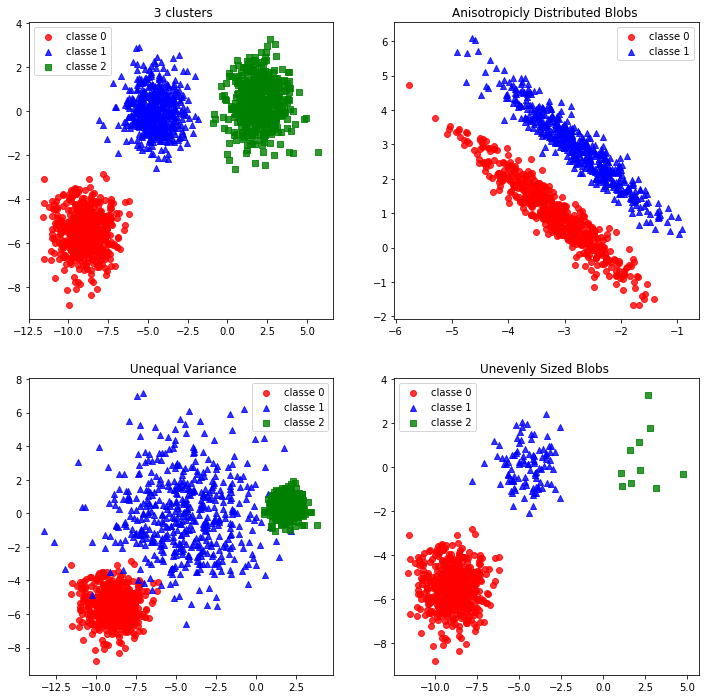

In [10]:
#plot_points_classe_2d(X_toy, y_toy, titre=' ')
plt.figure(figsize=(12, 12))
plt.subplot(2,2,1)
plot_points_classe_2d(X, y, titre=' 3 clusters')
plt.subplot(2,2,2)
plot_points_classe_2d(X_aniso, y_aniso, titre='Anisotropicly Distributed Blobs ')
plt.subplot(2,2,3)
plot_points_classe_2d(X_varied, y_varied, titre=' Unequal Variance')
plt.subplot(2,2,4)
plot_points_classe_2d(X_filtered, y_filtered, titre='Unevenly Sized Blobs ')

 &nbsp;
 
 
 
 <p style="text-align:justify;">  On peut remarquer distinctement les différents clusters des datasets. Le dataset "3 clusters" présente 3 clusters de variance égale alors que le dataset "Unequal Variance" possède des clusters de variance différente. On observe bien que les points appartenant à la classe 1 (en bleu) sont beaucoup plus eclatés que les points des deux autres classes. Enfin on oberve bien pour le dataset "Anisotropicly Distributed Blobs" les deux classes séparées par un axe et pour le dataset "Unevenly Sized Blobs" des classes de tailles très différentes puisque la classe 2 présente beaucoup moins de points que la classe 1 qui possède elle-même beaucoup moins de points que la classe 0. </p>
 


&nbsp;

&nbsp;


## 2. Classification hiérarchique ascendante

&nbsp;


 <p style="text-align:justify;">  Nous allons dans cette partie étudier une méthode de clustering appelée "Classification hiérarchique ascendante". Le but est de répartir un ensemble d'individus dans un certain nombre de classes. Comme pour toute méthode de clustering, il est nécessaire de disposer une mesure de dissimilarité entre les individus. La classification est dite ascendante car au début de l'algorithme tous les individus sont seuls dans une classe, puis sont rassemblés en classes de plus en plus grandes. Elle est dit hiérarchique car elle produit une hiérarchie une fois l'algorithme terminé. Cette à dire qu'au sommet de la hiérarchie, tous les individus sont regroupés. En bas de la hiérarchie, tous les individus sont seuls. Enfin, si l'on considère deux classes du regroupement, soit elles n'ont pas d'individus en commun, soit l'une est incluse dans l'autre. </p>


&nbsp;

### 2.1. Prise en main du clustering

&nbsp;


 <p style="text-align:justify;"> Dans cette première partie nous nous intéressons à la Classification Hiérarchique ascendante, implémentée par la fonction *AgglomerativeClustering* du module *cluster*. </p>

&nbsp;
Documentation sur la fonction AgglomerativeClustering : https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html

In [11]:
from sklearn.cluster import AgglomerativeClustering

 <p style="text-align:justify;"> On teste premièrement la fonction AgglomerativeClustering sur les données générées dans la section 1, puis on regarde graphiquement le résultat. On ne touche à aucun paramètre de la fonction. </p>



In [12]:
CAH_Toy = AgglomerativeClustering().fit(X_toy)
CAH_X = AgglomerativeClustering().fit(X)
CAH_Aniso = AgglomerativeClustering().fit(X_aniso)
CAH_Varied = AgglomerativeClustering().fit(X_varied)
CAH_Filtered = AgglomerativeClustering().fit(X_filtered)

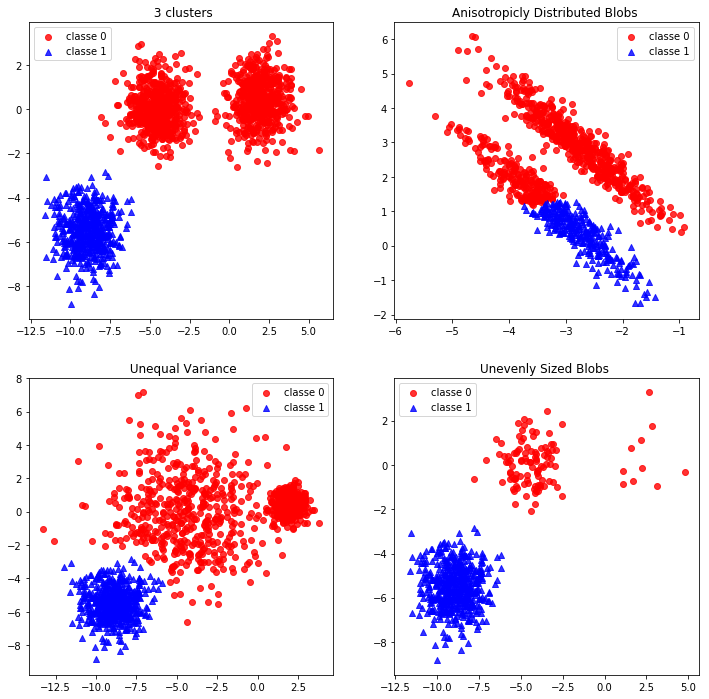

In [13]:
plt.figure(figsize=(12, 12))
plt.subplot(2,2,1)
plot_points_classe_2d(X, CAH_X.labels_ , titre=' 3 clusters')
plt.subplot(2,2,2)
plot_points_classe_2d(X_aniso,CAH_Aniso.labels_ , titre='Anisotropicly Distributed Blobs ')
plt.subplot(2,2,3)
plot_points_classe_2d(X_varied, CAH_Varied.labels_ , titre=' Unequal Variance')
plt.subplot(2,2,4)
plot_points_classe_2d(X_filtered, CAH_Filtered.labels_ , titre='Unevenly Sized Blobs ')

&nbsp;


 <p style="text-align:justify;"> On remarque que par défaut, la fonction choisi 2 comme nombre de clusters. Hormis pour le dataset "Anisotropicly Distributed Blobs" qui contient deux classes, les autres datasets contiennent 3 classes et donc la fonction *AgglomerativeClustering* n'a pas pu obtenir le clustering idéal. De plus pour le jeu de données 2, le clustering n'est pas celui attendu (voir figure dans la section 1). Il est donc nécessaire de s'intéresser aux paramètres de la fonction *AgglomerativeClustering*.  </p>
 
 &nbsp;


 <p style="text-align:justify;"> Les paramètres que l'on peut manipuler et qui vont fortement influencer sur le clustering sont le nombre de clusters, l'affinity (métrique utilisée pour le linkage) et le type de linkage utilisé. Par défaut, le nombre de clusters est 2, la métrique est la distance euclidienne et le linkage est la méthode de ward.  </p>
   &nbsp;

Les différentes métriques sont : 
* la distance **euclidienne**
* la distance **l1**
* la distance **l2** 
* la distance de **manhattan**
* la similarité **cosinus**

Les différentes linkages (méthodes utilisées pour regrouper les clusters) : 
* **average** : utilise la distance moyenne entre les points des clusters
* **complete** : utilise la distance maximale entre les points des clusters
* **ward** : regroupe les classes de sorte que l'augmentation de l'inertie interclasse soit maximum (ou que l'augmentation de l'inertie intraclasse soit minimum). 

Si **ward** est choisie, seule la distance euclidienne est possible. Dans la documentation de la fonction *AgglomerativeClustering*, il est indiqué qu'il y a ausi le linkage "Single" qui utilise la distance minimale entre les points des clusters. Mais cette fonction n'existe pas dans ma version de *SkLearn* (pourtant mise à jour ...).


&nbsp;


 <p style="text-align:justify;"> Nous allons regarder les résultats obtenus avec différentes valeurs du nombre de clusters pour le dataset "Unequal Variance", qui semble être un dataset compliqué étant donnée la forte variation de la classe 1 (cf figures lors de la présentation des datasets). On laisse les autres paramètres par défaut. </p>
 
 &nbsp;

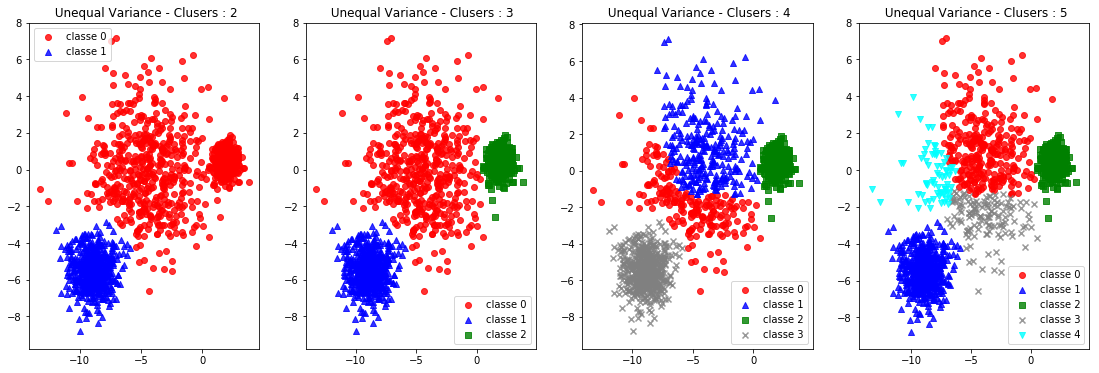

In [18]:
plt.figure(figsize=(19, 6))
for i in range(2,6):
    plt.subplot(1,4,i-1)
    CAH_Varied = AgglomerativeClustering(i).fit(X_varied)
    plot_points_classe_2d(X_varied, CAH_Varied.labels_ , titre=' Unequal Variance' + ' - Clusers : ' + str(i))

&nbsp;


 <p style="text-align:justify;"> On remarque que la fonction *AgglomerativeClustering* sépare les données de façon cohérente. Il est facile de voir en 2D que les données sont séparées de manière à former des clusters qui regroupent les données proches les unes des autres. Le nombre de cluster exacte est 3. La deuxième classe possède une grande variation, c'est donc logique que cette classe soit séparée en plusieurs classes lorsque le nombre de clusters augmente.</p>
 
&nbsp;


 <p style="text-align:justify;"> Nous allons maintenant nous intéresser aux paramètres *linkage* et *affinity*. Nous afficherons les résultats obtenus. Nous utiliersons deux datasets : "unequal variance" et "Anisotropicly Distributed Blobs". Nous fixerons le nombre de clusters pour le premier à 3, et pour le deuxième à 2.</p>

&nbsp;

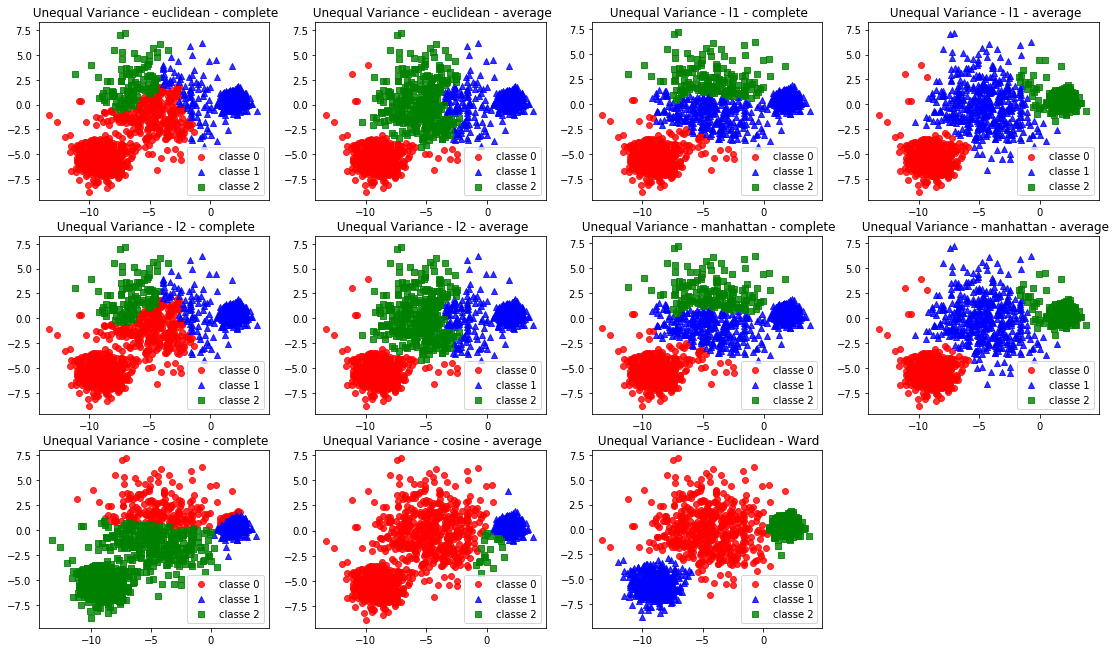

In [15]:
plt.figure(figsize=(19, 19))
affinity = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
linkage = ['complete', 'average']

k = 1
for i in affinity :
    for j in linkage :
        plt.subplot(5,4,k)
        CAH_Varied = AgglomerativeClustering(3, affinity = i, linkage = j).fit(X_varied)
        plot_points_classe_2d(X_varied, CAH_Varied.labels_ , titre=' Unequal Variance - ' + i + ' - ' + j)
        k=k+1
plt.subplot(5,4,k)   
CAH_Varied = AgglomerativeClustering(3).fit(X_varied)
plot_points_classe_2d(X_varied, CAH_Varied.labels_ , titre=' Unequal Variance - Euclidean - Ward')

&nbsp;


 <p style="text-align:justify;"> On obtient des résultats très différents selon la distance et la méthode utilisée pour regrouper les données. Ceci montre l'importance des paramètres lors de l'utilisation de la fonction *AgglomerativeClustering*. Globalement, avec ce dataset, lorsque le linkage "complete" est utilisée, les résultats ne sont pas bons. La similarité cosinus ne donne pas de bons résultats. Sinon pour le linkage "average" avec les autres distances donne des résultats corrects.</p>
 
&nbsp;

 <p style="text-align:justify;"> Nous allons maintenant regarder le dataset "Anisotropicly Distributed Blobs" pour regarder si certains paramètres permettent de regrouper les données en 2 clusters comme attendu. </p>
 
 &nbsp;

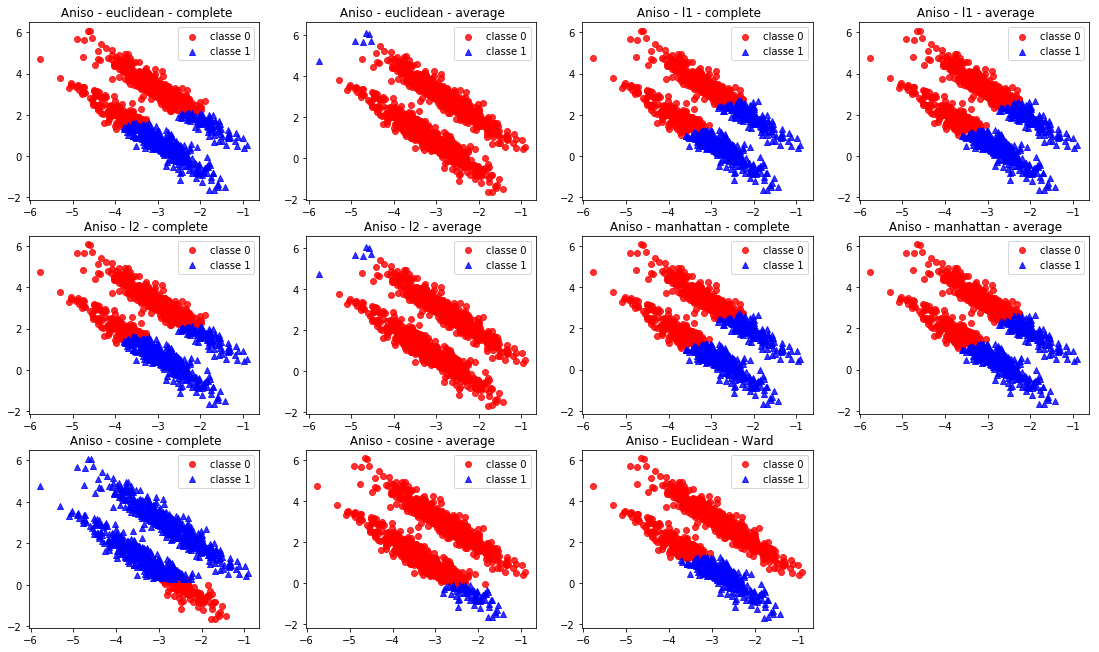

In [26]:
plt.figure(figsize=(19, 19))
affinity = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
linkage = ['complete', 'average']

k = 1
for i in affinity :
    for j in linkage :
        plt.subplot(5,4,k)
        CAH_Aniso = AgglomerativeClustering(2, affinity = i, linkage = j).fit(X_aniso)
        plot_points_classe_2d(X_aniso, CAH_Aniso.labels_ , titre=' Aniso - ' + i + ' - ' + j)
        k=k+1
plt.subplot(5,4,k)   
CAH_Aniso = AgglomerativeClustering(2).fit(X_aniso)
plot_points_classe_2d(X_aniso, CAH_Aniso.labels_ , titre=' Aniso - Euclidean - Ward')

&nbsp;


 <p style="text-align:justify;"> Aucune combinaison de paramètres permet d'obtenir le résultat attendu. Les données ne sont pas regroupées en 2 clusters selon le bon axe. Pour ce dataset encore, la similarité cosinus ne donne pas de bons résultats.</p>
 
&nbsp;

### 2.2. Etude du dendrogramme

&nbsp;

 <p style="text-align:justify;"> Nous allons générer deux jeux de données simulées de deux lois gaussiennes.</p>
 
 &nbsp;


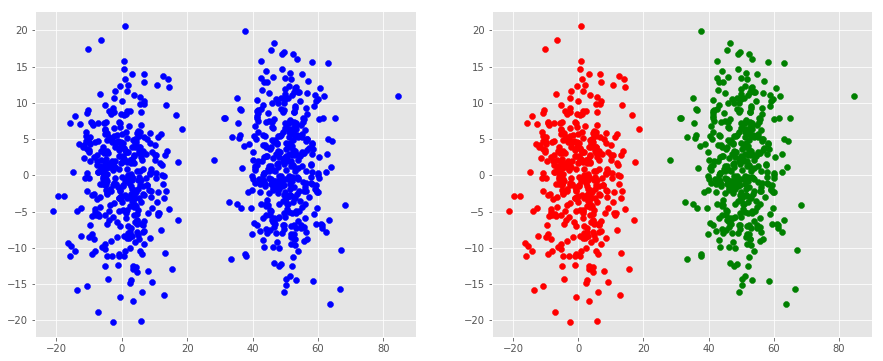

In [83]:
mu1 = [0,0]
mu2 = [50,1]

sigma = 7

X1 = np.random.normal(mu1, sigma, (400,2))
X2 = np.random.normal(mu2, sigma, (400,2))
X = np.concatenate((X1,X2))
np.random.shuffle(X)

plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1], c="blue") 
plt.subplot(1,2,2)
plt.scatter(X1[:,0],X1[:,1], c="red") 
plt.scatter(X2[:,0],X2[:,1], c = "green")



&nbsp;

<p style="text-align:justify;"> On observe bien sur le graphique ci-dessus les données des deux gaussiennes. Nous allons maintenant utiliser la fonction *AgglomerativeClustering* pour séparer les données afin d'obtenir des clusters. Nous prendrons différentes valeurs pour le nombre de clusters.</p>
 
 &nbsp;

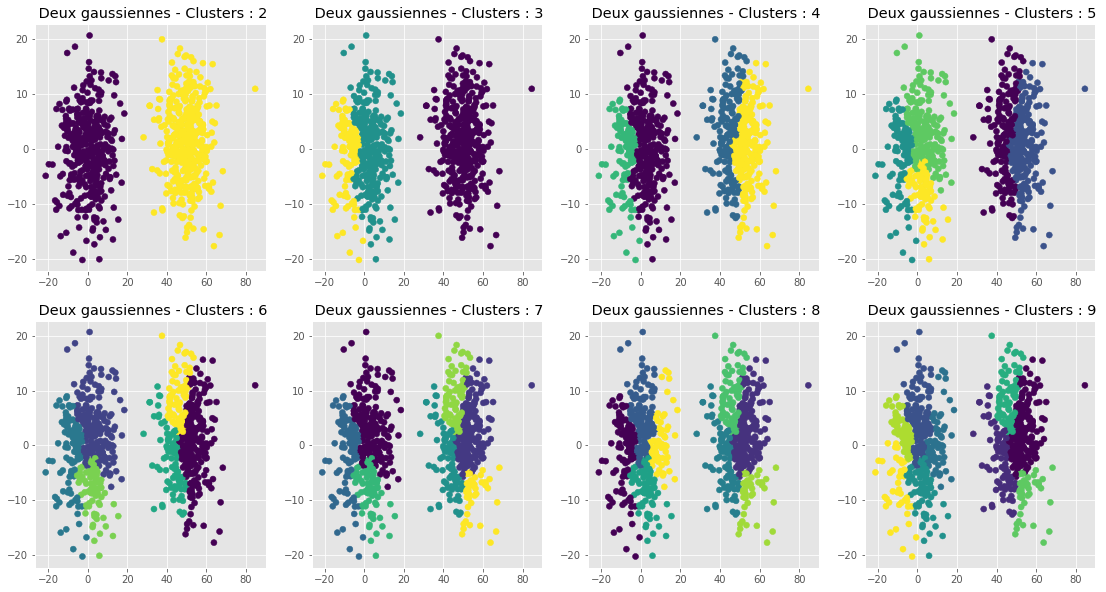

In [84]:
plt.figure(figsize=(19, 10))
for i in range(2,10):
    plt.subplot(2,4,i-1)
    CAH_Gaussien = AgglomerativeClustering(i).fit(X)
    plt.scatter(X[:,0], X[:,1], c = CAH_Gaussien.labels_ )
    plt.title(' Deux gaussiennes - Clusters : ' + str(i))


&nbsp;

<p style="text-align:justify;"> Pour 2 clusters, le clustering a donné les résultats attendus. On a décrit précedemment le fonctionnement de la classification ascendante hiérarchique. Les données sont regroupées en classe de plus en plus grandes. Cela permet de construire un dendrogramme. Pour obtenir une partition des données, il suffit de découper le dendrogramme à une certaine hauteur. Ainsi, lorsqu'on passe de deux clusters à trois clusters, une donnée qui appartenait dans le cluster 1 lors du clustering à deux clusters, pourra appartenir soit au cluster 1 soit au nouveau cluster créé en fonction de la découpe du dendrogramme. Lorsque le nombre de données est faible, le dendrogramme est exploitable visuellement et peut donner une indication sur le nombre de classes à retenir. Dans notre cas le nombre de données est trop importante. Dans l'exemple suivant nous pourrons observer un dendrogramme. </p>

&nbsp;

<p style="text-align:justify;">  Nous allons prendre comme dataset le jeu de données "Toy". On rappelle comment sont réparties les données : </p>

&nbsp;

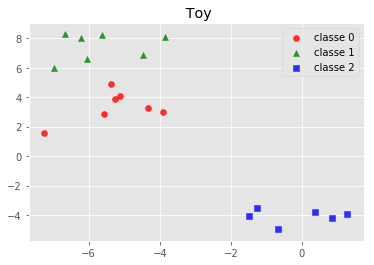

In [85]:
plot_points_classe_2d(X_toy, y_toy, titre=' Toy')

&nbsp;

<p style="text-align:justify;"> Affichons maintenant le dendrogramme. </p>

&nbsp;

Text(0.5,1,'Dendrogramme du jeu de données Toy')

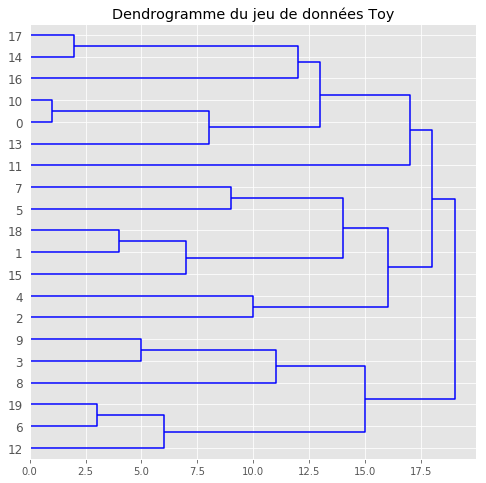

In [90]:
plot_dendogram(CAH_Toy, label_points=None)
plt.title("Dendrogramme du jeu de données Toy")

&nbsp;

<p style="text-align:justify;"> Pour obtenir trois clusters, il faut alors enlever les deux branchements les plus hauts dans le dendrogramme. Le cluster comprenant les points (9, 3, 8, 19, 6, 12) est alors en regardant le dendrogramme, le cluster le plus spécifique. Ceci est confirmé graphiquement, on voit que ce cluster est plus éloigné par rapport aux 2 autres. Il est aussi possible de connaître en regardant le dendrogramme les points qui sont les plus similaires, cela correspond aux branchements les plus petits. Par exemple les points 0 et 10 sont les plus proches, ensuite les points 14 et 17, puis 19 et 6, et ainsi de suite. On peut d'ailleurs retrouver comment le dendrogramme a été créé en appellant la fonction *children_* :</p>

&nbsp;

In [92]:
print(CAH_Toy.children_)

[[ 0 10]
 [14 17]
 [ 6 19]
 [ 1 18]
 [ 3  9]
 [12 22]
 [15 23]
 [13 20]
 [ 5  7]
 [ 2  4]
 [ 8 24]
 [16 21]
 [27 31]
 [26 28]
 [25 30]
 [29 33]
 [11 32]
 [35 36]
 [34 37]]


 &nbsp;

<p style="text-align:justify;"> Ainsi quand on veut obtenir 2 clusters, on coupe le branchement entre les noeuds 34 et 37. Si on veut avoir 3 clusters, on coupe le branchement entre les noeuds 35 et 36. Il reste alors les noeurs 34, 35, 36 et leurs enfants. L'avantage de la classification ascendante hiérarchique est donc que si on veut calculer un clustering avec un nombre de clusters non prédéfini, il n'est pas nécessaire de re-calculer le clustering en changeant le paramètre concernant le nombre de clusters. Il suffit juste d'élaguer au fur et a mesure les branchements afin d'obtenir le nombre de clusters souhaité. Je n'ai pas pu illuster ceci car je n'ai pas trouvé comment faire avec *sklearn*... </p>

&nbsp;

## 3. Test de la méthode K-means

&nbsp;

 <p style="text-align:justify;"> Nous allons maintenant nous intéresser à la méthode des *k-means*. Nous utiliserons la fonction *KMeans* de *sklearn*. Testons dans un premier temps la fonction sur nos jeux de données utilisées dans la première partie, sans toucher aux paramètres.</p>
 
&nbsp;

Text(0.5,1,'Unevenly Sized Blobs')

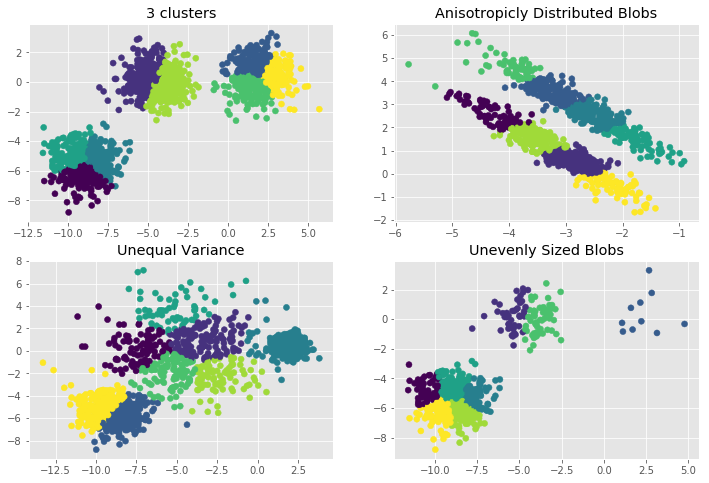

In [97]:
from sklearn.cluster import KMeans

KM_Toy = AgglomerativeClustering().fit(X_toy)
KM_X = KMeans().fit(X)
KM_Aniso = KMeans().fit(X_aniso)
KM_Varied = KMeans().fit(X_varied)
KM_Filtered = KMeans().fit(X_filtered)

plt.figure(figsize=(12, 8))

plt.subplot(2,2,1)
plt.scatter(X[:,0], X[:,1], c = KM_X.labels_ )
plt.title('3 clusters')

plt.subplot(2,2,2)
plt.scatter(X_aniso[:,0], X_aniso[:,1], c = KM_Aniso.labels_ )
plt.title('Anisotropicly Distributed Blobs')

plt.subplot(2,2,3)
plt.scatter(X_varied[:,0], X_varied[:,1], c = KM_Varied.labels_ )
plt.title('Unequal Variance')

plt.subplot(2,2,4)
plt.scatter(X_filtered[:,0], X_filtered[:,1], c = KM_Filtered.labels_ )
plt.title('Unevenly Sized Blobs')


&nbsp;

 <p style="text-align:justify;"> Par défaut, le nombre de cluster est donc de 8. Regardons les résultats avec *KMeans* en utilisant pour chaque dataset le bon nombre de clusters. </p>
 
&nbsp;

Text(0.5,1,'Unevenly Sized Blobs')

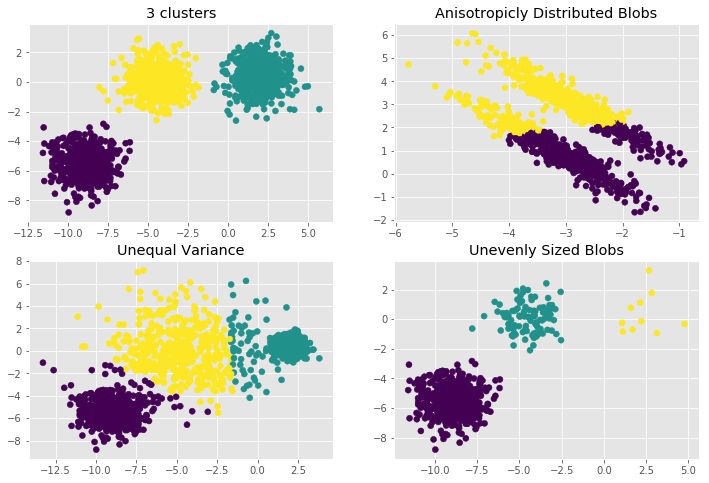

In [98]:
KM_Toy = AgglomerativeClustering().fit(X_toy)
KM_X = KMeans(3).fit(X)
KM_Aniso = KMeans(2).fit(X_aniso)
KM_Varied = KMeans(3).fit(X_varied)
KM_Filtered = KMeans(3).fit(X_filtered)

plt.figure(figsize=(12, 8))

plt.subplot(2,2,1)
plt.scatter(X[:,0], X[:,1], c = KM_X.labels_ )
plt.title('3 clusters')

plt.subplot(2,2,2)
plt.scatter(X_aniso[:,0], X_aniso[:,1], c = KM_Aniso.labels_ )
plt.title('Anisotropicly Distributed Blobs')

plt.subplot(2,2,3)
plt.scatter(X_varied[:,0], X_varied[:,1], c = KM_Varied.labels_ )
plt.title('Unequal Variance')

plt.subplot(2,2,4)
plt.scatter(X_filtered[:,0], X_filtered[:,1], c = KM_Filtered.labels_ )
plt.title('Unevenly Sized Blobs')

&nbsp;

 <p style="text-align:justify;"> Comme pour la classification ascendante hiérarchique, les résultats sont bon. Cependant pour le dataset "Anisotropicly Distributed Blobs", le clustering n'a pas sorti les deux clusters attendus. </p>
 
&nbsp;

<p style="text-align:justify;"> En lisant la documentation de la fonction *KMeans* de *sklearn*, on peut voir les paramètres qui vont avoir une grande influence sur le résultat. Tout d'abord évidemment le nombre de clusters, mais aussi l'initialisation des centroïdes au début de l'algorithme ainsi que le nombre de fois que l'algorithme va être effectué. En effet, les résultats changent en fonction de l'initialisation des centroïdes. Ces deux paramètres sont les suivants : </p>

* **init** : choix de la méthode d'initialisation des centroïdes. Par défaut "k_means++", initialise les centroïdes de façon à ce qu'ils soient distants les uns des autres, permettant d'améliorer les résultats par rapport à une initialisation "random" qui choisi comme centroïde un nombre *n* de données avec *n* le nombre de cluster souhaité.
* **n_init** : nombre de fois que l'algorithme va être exécuté (10 par défaut) avec différentes intialiations des centroïdes. Parfois l'initialisation des centroïdes conduit a une non convergence ou bien a des clusters qui changent drastiquement d'une itération à une autre. Pour éviter ce problème, ce paramètre indique combien d'initilisation différentes de centroïdes vont être utilisées. Le résultat final sera le meilleur résultat de *n_init* exécutions consécutives en terme d'iniertie.

&nbsp;

<p style="text-align:justify;"> Regardons l'influence de ces paramètres sur nos données :  </p>

&nbsp;


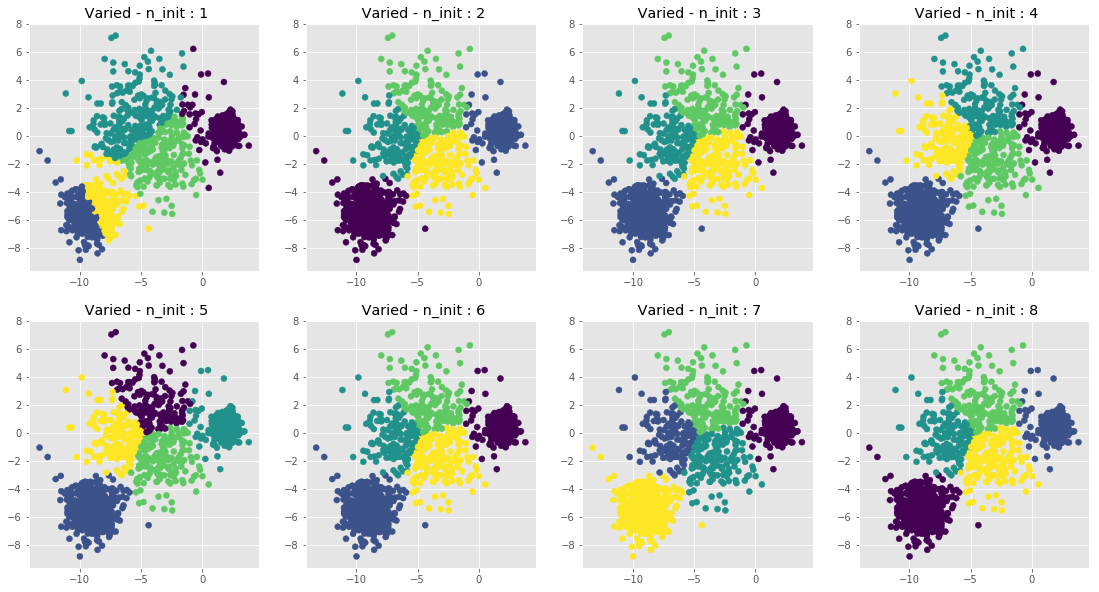

In [129]:
plt.figure(figsize=(19, 10))
for i in range(1,9):
    plt.subplot(2,4,i)
    KM_Varied = KMeans(5, n_init = i).fit(X_varied)
    plt.scatter(X_varied[:,0], X_varied[:,1], c = KM_Varied.labels_ )
    plt.title(' Varied - n_init : ' + str(i))

&nbsp;

<p style="text-align:justify;"> On peut alors voir que pour *n_init = 1*, les résultats sont différents et les données sont moins bien regroupés. Il faut donc faire attention à ces paramètres. Mais par défaut ce paramètre est à 10, ce qui permet d'avoir de bons résultats.</p>

&nbsp;

<p style="text-align:justify;"> Les limites de l'algorithme des Kmeans sont donc dans un premier temps l'initialisation des centroïdes. Le paramètre **n_init** augmente considérablement le temps d'exécution lorsqu'il devient grand. De plus une initialisation incorrecte des centroïdes peut conduire à une non convergence de l'algorithme. Dans un second temps, il faut exécuter plusieurs fois l'algorithme avec différentes valeurs de cluster, regarder la courbe représentant l'évolution de l'inertie intra-classes et choisir alors le nombre de cluster avec la méthode du coude. Ceci coûte en temps de calcul. Alors qu'on a vu avec la méthode CHA qu'il n'est pas nécessaire d'effectuer plusieurs exécutions de l'algorithme.</p>


&nbsp;


### 3.1 MiniBatch Kmeans


&nbsp;

<p style="text-align:justify;"> Pour les gros jeux de données, KMeans peut être pénalisé par la mise à jour du centre de chaque cluster. Pour pallier ce problème, il existe une alternative appelée *MiniBatchKMeans*. L'idée de cette méthode est de ne pas utiliser l'ensemble du dataset mais d'utiliser des échantillons (tirées au hasard) de taille définies en paramètres. Ces échantillons permettent de reduire le nombre d'itérations requis pour que l'algorithme converge vers une solution locale. L'idée est qu'à chaque itération, les individus de l'échantillon sont affectés à la classe du centroïde le plus proche. Puis les centroïdes sont mis à jour. Donc les centroïdes sont mis à jour pour chaque échantillon et non pour chaque données comme lors de la méthode KMeans. D'où pour un grand nombre de données, la convergence sera plus rapide avec l'algorithme *MiniBatch Kmeans* car il y aura beaucoup moins de mise à jour des centroïdes. </p>

&nbsp;

<p style="text-align:justify;"> On peut alors se demander ce qu'il en est de la qualité du clustering obtenue. C'est ce que nous allons voir en générant un jeu de données de 5000 points composé de trois gaussiennes. Nous comparerons alors le temps de calcul et la qualité du clustering en affichant l'inertie intra-classe. Plus l'inertie est petite, meilleur est le clustering.</p>


In [197]:
from sklearn.cluster import MiniBatchKMeans
import time

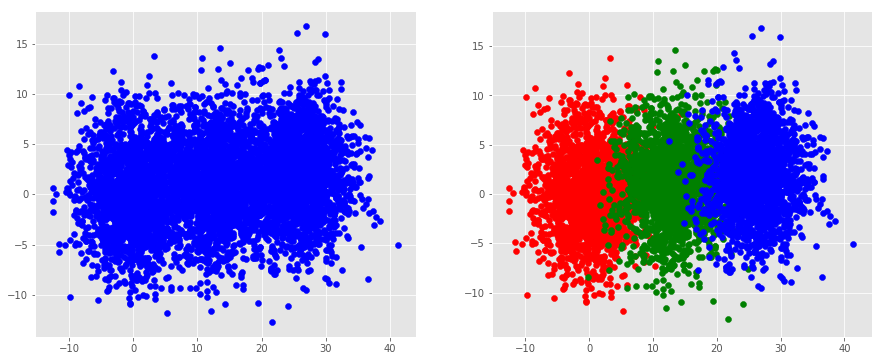

In [208]:

mu1 = [0,0]
mu2 = [13,1]
mu3 = [26,2]

sigma = 4

X1 = np.random.normal(mu1, sigma, (2000,2))
X2 = np.random.normal(mu2, sigma, (2000,2))
X3 = np.random.normal(mu3, sigma, (2000,2))
X = np.concatenate((X1,X2,X3))
np.random.shuffle(X)

plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1], c="blue") 
plt.subplot(1,2,2)
plt.scatter(X1[:,0],X1[:,1], c="red") 
plt.scatter(X2[:,0],X2[:,1], c = "green")
plt.scatter(X3[:,0],X3[:,1], c = "blue")

&nbsp;

<p style="text-align:justify;"> Voici donc ci-dessus les points obtenus. On va alors utiliser la méthode des *KMeans* et la méthode *MiniBatch KMeans*. Les paramètres importants de la fonction *MiniBatchKMeans* sont : </p>

* **n_clusters** : nombre de clusters
* **init** : même chose que pour *KMeans*
* **batch_size** : taille des échantillons tirées à chaque itération (par défaut 100)

&nbsp;

<p style="text-align:justify;"> On affichera le résultat obtenu ainsi que le temps d'exécution et l'inertie obtenue. </p>

&nbsp;

In [209]:
k_means_gaussian = KMeans(init='k-means++', n_clusters=3)
t0 = time.time()
k_means_gaussian.fit(X)
t_batch = time.time() - t0


mbk_gaussian = MiniBatchKMeans(init='k-means++', n_clusters=3, batch_size = 100)
t0 = time.time()
mbk_gaussian.fit(X)
t_mini_batch = time.time() - t0

Text(-13,15,'Temps: 0.0247s\n Inertie: 174044')

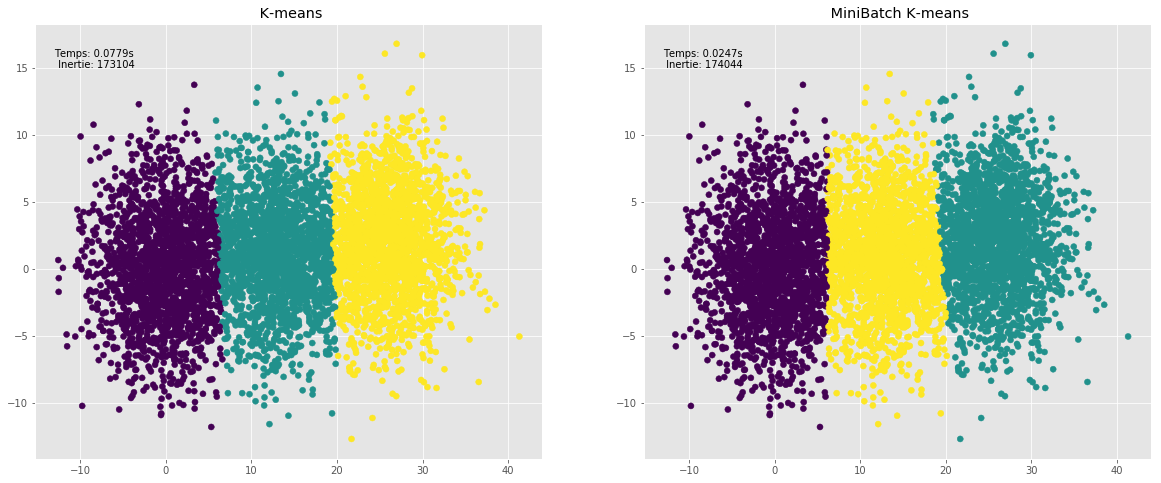

In [222]:
plt.figure(figsize=(20, 8))

plt.subplot(1,2,1)
plt.scatter(X[:,0], X[:,1], c = k_means_gaussian.labels_ )
plt.title(' K-means')
plt.text(-13, 15, 'Temps: %.4fs\n Inertie: %.0f' % (t_batch, k_means_gaussian.inertia_))

plt.subplot(1,2,2)
plt.scatter(X[:,0], X[:,1], c = mbk_gaussian.labels_ )
plt.title(' MiniBatch K-means')
plt.text(-13, 15, 'Temps: %.4fs\n Inertie: %.0f' % (t_mini_batch, mbk_gaussian.inertia_))

&nbsp;

<p style="text-align:justify;"> Voici donc les résultats obtenus. Le temps d'exécution est trois fois plus rapide avec *MiniBatch KMeans* pour une perte d'inertie très petite par rapport à *KMeans* (173103 contre 174044). </p>

&nbsp;

<p style="text-align:justify;"> On peut donc conclure que pour un jeu de données important, l'utilisation de *MiniBatch KMeans* permet de réduire considérablement le temps d'exécution, en restant asez performant par rapport à *KMeans*. </p>

&nbsp;

## 4. Généralisation sur des données réelles

&nbsp;

 <p style="text-align:justify;"> Dans cette partie, nous allons tester les deux algorithmes étudiés lors de TP, sur plusieurs jeux de données :</p>

* **ds2.dat** : Deux losanges connectés.
* **george.dat** : Ecriture bruitée du mot GEORGE
* **digits** : jeu de données qui contient des scans de chiffres manuscrits
 
&nbsp;

&nbsp;

 <p style="text-align:justify;"> On s'intéresse dans un premier temps aux losanges connectés. Ce jeux de données contient 8000 données bi-dimensionnelles. Affichons les :</p>

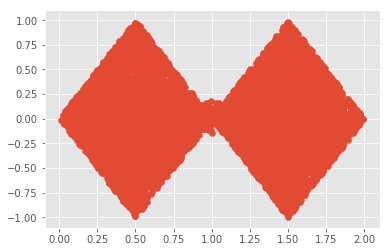

In [215]:
ds2 = pd.read_excel("ds2.xlsx", header = None)
plt.scatter(ds2[0], ds2[1])
plt.show()

&nbsp;

 <p style="text-align:justify;"> Regardons maintenant les résultats obtenenus avec les deux méthodes de clustering étudiés. Comme le dataset comporte un grand nombre de données, nous allons utiliser *MiniBatch KMeans*. Le problème est que nous ne savons pas à l'avance pour cet exemple le bon nombre de cluster. C'est pourquoi on introduit le **coefficient de silhouette**. Ce coefficient est une mesure de qualité d'une partition d'un ensemble de données. Pour chaque point, son coefficient de silhouette est la différence entre la distance moyenne avec les points du même groupe que lui (cohésion) et la distance moyenne avec le points des autres groupes voisins (séparation). Si cette différence est négative, le point est en moyenne plus proche du groupe voisin que du sien : il est donc mal classé. A l'inverse, si cette différence est positive, le point est en moyenne plus proche de son groupe que du groupe voisin : il est donc bien classé. Le coefficient de silhouette proprement dit est la moyenne du coefficient de silhouette pour tous les points. (définition claire trouvée sur *Wikipedia*). Donc plus le coefficient de silhouette est élevé, meilleur est le clustering.</p>
 
  <p style="text-align:justify;"> Intéressons nous dans un premier temps à la classification hiérarchique ascendante. Calculons le clustering avec *sklearn* pour plusieurs valeurs du nombre de cluster et regardons comment se comporte le coefficient de silhouette. </p>

&nbsp;



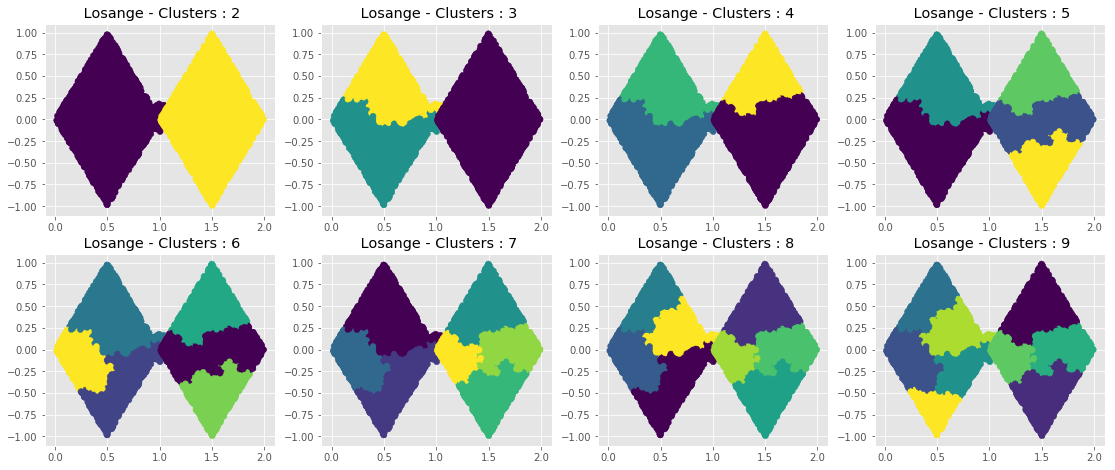

In [242]:
from sklearn.metrics import silhouette_score 

nb_cluster = [n for n in range(2,10)]
silhouette_scores = [] 

plt.figure(figsize=(19, 12))
for i in nb_cluster:
    plt.subplot(3,4,i-1)
    CAH_losange = AgglomerativeClustering(i)
    
    plt.scatter(ds2[0], ds2[1], c = CAH_losange.fit_predict(ds2))
    plt.title(' Losange - Clusters : ' + str(i))
    silhouette_scores.append(silhouette_score(ds2, CAH_losange.fit_predict(ds2)))
    


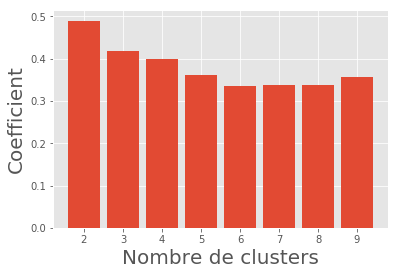

Pour 2 clusters, le coefficient de silhouette est de 0.48984219718061717
Pour 3 clusters, le coefficient de silhouette est de 0.4191785043531196
Pour 4 clusters, le coefficient de silhouette est de 0.39894406500907476
Pour 5 clusters, le coefficient de silhouette est de 0.36232035605298174
Pour 6 clusters, le coefficient de silhouette est de 0.33562338613533443
Pour 7 clusters, le coefficient de silhouette est de 0.3378593768387056
Pour 8 clusters, le coefficient de silhouette est de 0.33828028510963315
Pour 9 clusters, le coefficient de silhouette est de 0.3564257927927303


In [243]:
plt.bar(nb_cluster, silhouette_scores) 
plt.xlabel('Nombre de clusters', fontsize = 20) 
plt.ylabel('Coefficient', fontsize = 20) 
plt.show() 

for i in nb_cluster :
    print("Pour {} clusters, le coefficient de silhouette est de {}".format(i, silhouette_scores[i-2]))


  <p style="text-align:justify;"> Le coefficient de silhouette nous indique que le nombre de cluster optimal est 2, en effet c'est celui qui est le plus grand. L'exécution a été assez longue du fait qu'avec *sklearn* il a fallu pour chaque valeur de cluster, recalculer la classification ascendante hiérarchique.</p>

&nbsp;

  <p style="text-align:justify;"> Nous allons maintenant effectuer la même chose avec *MiniBatch KMeans*.</p>

&nbsp;

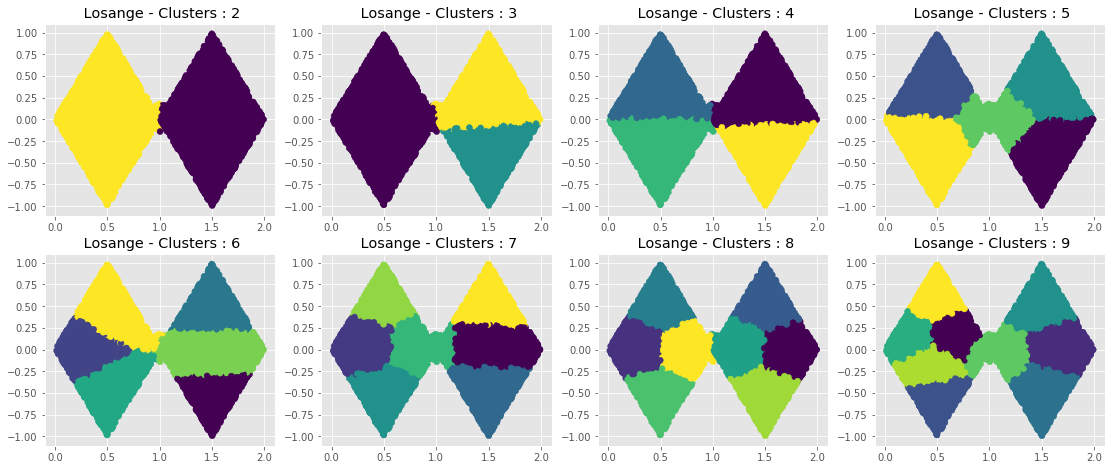

In [244]:
silhouette_scores2 = [] 
inertie = []

plt.figure(figsize=(19, 12))
for i in nb_cluster:
    plt.subplot(3,4,i-1)
    mbk_losange = MiniBatchKMeans(init='k-means++', n_clusters=i, batch_size = 100).fit(ds2)
    plt.scatter(ds2[0], ds2[1], c = mbk_losange.labels_)
    plt.title(' Losange - Clusters : ' + str(i))
    silhouette_scores2.append(silhouette_score(ds2, mbk_losange.labels_))

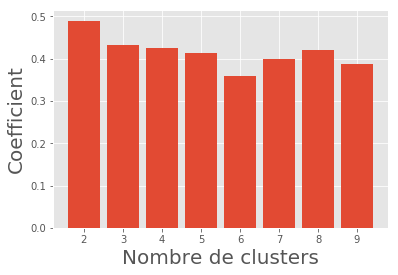

Pour 2 clusters, le coefficient de silhouette est de 0.48993399545937594
Pour 3 clusters, le coefficient de silhouette est de 0.4330506472853223
Pour 4 clusters, le coefficient de silhouette est de 0.4250176356178625
Pour 5 clusters, le coefficient de silhouette est de 0.41423695495146784
Pour 6 clusters, le coefficient de silhouette est de 0.35969049803675446
Pour 7 clusters, le coefficient de silhouette est de 0.40030273854480697
Pour 8 clusters, le coefficient de silhouette est de 0.4214992491502935
Pour 9 clusters, le coefficient de silhouette est de 0.3878012517324856


In [248]:
plt.bar(nb_cluster, silhouette_scores2) 
plt.xlabel('Nombre de clusters', fontsize = 20) 
plt.ylabel('Coefficient', fontsize = 20) 
plt.show() 

for i in nb_cluster :
    print("Pour {} clusters, le coefficient de silhouette est de {}".format(i, silhouette_scores2[i-2]))

<p style="text-align:justify;"> Avec *MiniBatch KMeans*, on obtient encore une fois un nombre optimal de cluster de 2. Globalement l'algorithme donne de légers meilleurs résultats qu'avec la CHA. </p>

&nbsp;

&nbsp;

<p style="text-align:justify;"> Intéressons nous maintenant au jeu de données **george** qui est l'ecriture bruitée du mot George. Affichons dans un premier temps le jeu de données. </p>

&nbsp;

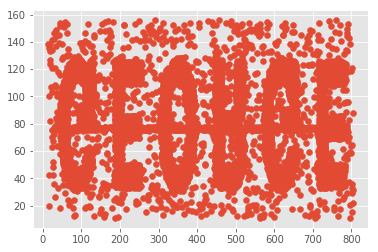

In [253]:
george = pd.read_excel("george.xlsx", header = None)
plt.scatter(george[0], george[1])
plt.show()


In [254]:
george.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 2 columns):
0    8000 non-null float64
1    8000 non-null float64
dtypes: float64(2)
memory usage: 125.1 KB


<p style="text-align:justify;"> Comme pour le jeu de données, précédent, le nombre de données est de 8000. </p>

&nbsp;

<p style="text-align:justify;"> Testons la classification hiérarchique ascendante sur ce dataset pour plusieurs valeurs du nombre de cluster, puis affichons les coefficients de silhouette. </p>

&nbsp;

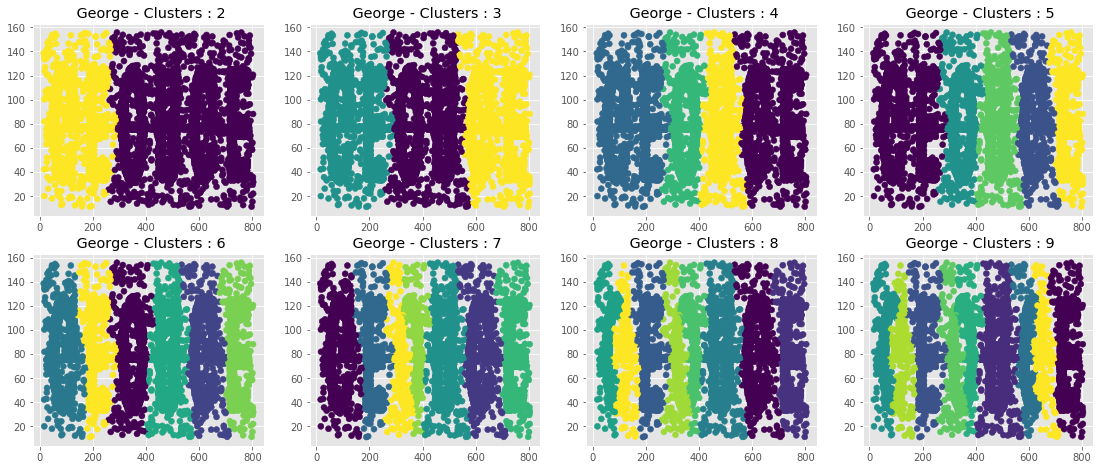

In [267]:
from sklearn.metrics import silhouette_score 

nb_cluster = [n for n in range(2,10)]
silhouette_scores = [] 

plt.figure(figsize=(19, 12))
for i in nb_cluster:
    plt.subplot(3,4,i-1)
    CAH_george = AgglomerativeClustering(i)
    
    plt.scatter(george[0], george[1], c = CAH_george.fit_predict(george))
    plt.title(' George - Clusters : ' + str(i))
    silhouette_scores.append(silhouette_score(george, CAH_george.fit_predict(george)))

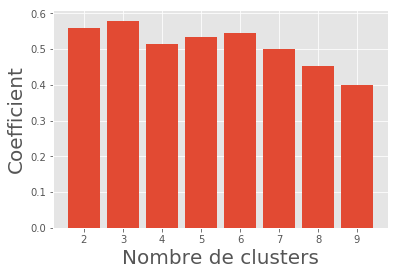

Pour 2 clusters, le coefficient de silhouette est de 0.55794510105784
Pour 3 clusters, le coefficient de silhouette est de 0.5791652971707784
Pour 4 clusters, le coefficient de silhouette est de 0.5149094512757632
Pour 5 clusters, le coefficient de silhouette est de 0.5325988809616696
Pour 6 clusters, le coefficient de silhouette est de 0.5443027047119313
Pour 7 clusters, le coefficient de silhouette est de 0.5013666493865094
Pour 8 clusters, le coefficient de silhouette est de 0.45347328478051546
Pour 9 clusters, le coefficient de silhouette est de 0.39989205563757835


In [266]:
plt.bar(nb_cluster, silhouette_scores) 
plt.xlabel('Nombre de clusters', fontsize = 20) 
plt.ylabel('Coefficient', fontsize = 20) 
plt.show() 

for i in nb_cluster :
    print("Pour {} clusters, le coefficient de silhouette est de {}".format(i, silhouette_scores[i-2]))

&nbsp;

<p style="text-align:justify;"> Le nombre optimal de cluster est de 3. </p>

&nbsp;

<p style="text-align:justify;"> Testons le clustering avec *MiniBatch KMeans*. </p>

&nbsp;

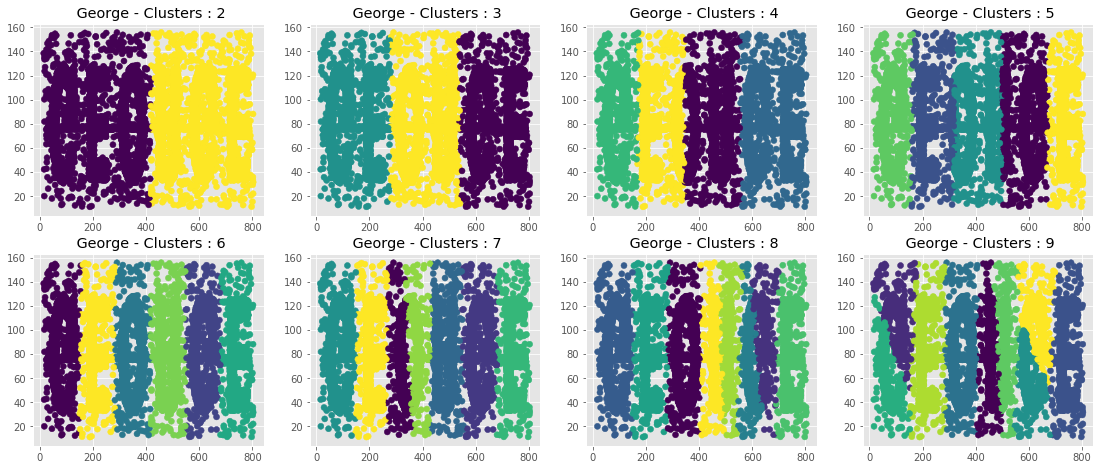

In [268]:
silhouette_scores2 = [] 
inertie = []

plt.figure(figsize=(19, 12))
for i in nb_cluster:
    plt.subplot(3,4,i-1)
    mbk_george = MiniBatchKMeans(init='k-means++', n_clusters=i, batch_size = 100).fit(george)
    plt.scatter(george[0], george[1], c = mbk_george.labels_, cmap='viridis')
    plt.title(' George - Clusters : ' + str(i))
    silhouette_scores2.append(silhouette_score(george, mbk_george.labels_))

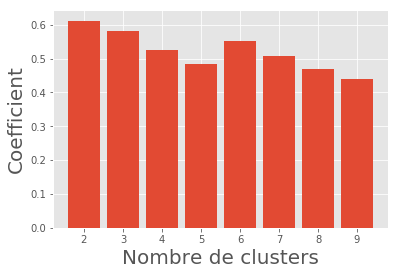

Pour 2 clusters, le coefficient de silhouette est de 0.6118928311306413
Pour 3 clusters, le coefficient de silhouette est de 0.5806277280219255
Pour 4 clusters, le coefficient de silhouette est de 0.524150083485405
Pour 5 clusters, le coefficient de silhouette est de 0.4835392227362564
Pour 6 clusters, le coefficient de silhouette est de 0.5516960738589509
Pour 7 clusters, le coefficient de silhouette est de 0.5088343637989614
Pour 8 clusters, le coefficient de silhouette est de 0.4706740163366622
Pour 9 clusters, le coefficient de silhouette est de 0.4389060308717272


In [269]:
plt.bar(nb_cluster, silhouette_scores2) 
plt.xlabel('Nombre de clusters', fontsize = 20) 
plt.ylabel('Coefficient', fontsize = 20) 
plt.show() 

for i in nb_cluster :
    print("Pour {} clusters, le coefficient de silhouette est de {}".format(i, silhouette_scores2[i-2]))

&nbsp;

<p style="text-align:justify;"> Le nombre optimal de cluster est de 2, ce qui diffère du résultta obtenu avec la CHA. Le coefficient de silhouette obtenue est meilleure pour la méthode *MiniBatch KMeans*.</p>

&nbsp;

<p style="text-align:justify;"> Testons le clustering avec *MiniBatch KMeans*. </p>

&nbsp;

## 5. Utilisation de méthodes de clustering pour la classification

&nbsp;

<p style="text-align:justify;"> Nous allons dans cette partie utiliser le dataset *digits* de *sklearn* en ne gardant que deux chiffres. Le dataset contient des scans de chiffre manuscrit de 8 pixels par 8 pixels. L'objectif va être de séparer les deux chiffres en utilisant une méthode de clustering. Les données du dataset ont un label donc nous pourrons calculer un score de classification. Comme pour les parties précédentes, nous testerons plusieurs méthodes de clustering. Notons que nous voulons séparer les données en deux, donc le nombre de cluster sera de 2.  </p>

&nbsp;


Tout d'abord, importants le dataset en ne gardant que 2 deux chiffres. Nous prendrons arbitrairement les chiffres 6 et 8.

In [372]:
from sklearn import datasets
digits = datasets.load_digits()
ind = ((digits.target == 6) | (digits.target == 8))
X_digits = digits.data[ind, :]
Y_digits = digits.target[ind]
print(X_digits.shape)
print(Y_digits.shape)

(355, 64)
(355,)


&nbsp;

<p style="text-align:justify;"> On obtient alors un dataset de 355 données à 64 variables. </p>

&nbsp;

## 5.1 Classification hiérarchique ascendante

<p style="text-align:justify;"> Commençons par la classification ascendante hiérarchique. </p>

In [373]:
from sklearn.metrics import confusion_matrix
CHA_digits = AgglomerativeClustering(2).fit(X_digits)

&nbsp;

<p style="text-align:justify;"> Les 2 clusters ainsi créés ont comme label 0 et 1. Les quelques lignes de code suivantes permettent juste d'identifier à quoi correspondent la classe 0 et 1 (si 0 correspond au chiffre 6 ou 8 et vice vera). </p>

&nbsp;

In [375]:
ind2 = ((CHA_digits.labels_ == 0))
X_digits_2 = X_digits[ind2, :]
Y_digits_2 = Y_digits[ind2]

ind3 = ((CHA_digits.labels_ == 1))
X_digits_3 = X_digits[ind3, :]
Y_digits_3 = Y_digits[ind3]

print(Y_digits_2)
print(Y_digits_3)


[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 6 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 8 6 6 6 6 6 6 6 6 6 6 8 6 6 8 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 8 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


In [376]:
from sklearn.metrics import accuracy_score

resultat = []
for i in range(0,len(CHA_digits.labels_)): 
    resultat.append(CHA_digits.labels_[i])
    if (CHA_digits.labels_[i] == 0):
        resultat[i] = 8
    if (CHA_digits.labels_[i] == 1):
        resultat[i] = 6
pd.DataFrame(confusion_matrix(Y_digits,resultat), columns = [8, 6], index = [8, 6])


,8,6
8,180,1
6,4,170


&nbsp;

<p style="text-align:justify;"> On a affiché ci-dessus la table de contingence. On observe qu'il y a eu une seule erreur de classification pour le chiffre 8 et 4 erreurs pour le chiffre 6. On peut finalement calculé le score obtenu en clasification. </p>

&nbsp;

In [377]:
print("Le score obtenu en classification est de : %.4f " %accuracy_score(Y_digits, resultat))

Le score obtenu en classification est de : 0.9859 


&nbsp;

## 5.1 MiniBatch KMeans

<p style="text-align:justify;"> Regardons maintenant la classification obtenue avec *MiniBatch KMeans*. On reprend la même méthode que pour la CHA. </p>

In [380]:
mbk_digits = MiniBatchKMeans(init='k-means++', n_clusters=2, batch_size = 100).fit(X_digits)

In [381]:
ind4 = ((mbk_digits.labels_ == 0))
X_digits_4 = X_digits[ind4, :]
Y_digits_4 = Y_digits[ind4]

ind5 = ((mbk_digits.labels_ == 1))
X_digits_5 = X_digits[ind5, :]
Y_digits_5 = Y_digits[ind5]

print(Y_digits_4)
print(Y_digits_5)

[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 6 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 8 6 6 6 6 6 6 6 6 6 6 6 6 8 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


In [383]:
resultat2 = []
for i in range(0,len(mbk_digits.labels_)): 
    resultat2.append(mbk_digits.labels_[i])
    if (mbk_digits.labels_[i] == 0):
        resultat2[i] = 8
    if (mbk_digits.labels_[i] == 1):
        resultat2[i] = 6
pd.DataFrame(confusion_matrix(Y_digits,resultat2), columns = [8, 6], index = [8, 6])

,8,6
8,180,1
6,2,172


In [384]:
print("Le score obtenu en classification est de : %.4f " %accuracy_score(Y_digits, resultat2))

Le score obtenu en classification est de : 0.9915 


&nbsp;

<p style="text-align:justify;"> On obtient finalement un meilleur score en classification que pour la CHA. </p>

&nbsp;

<p style="text-align:justify;"> On peut aussi regarder en classification sur l'ensemble du jeu de données *digits*. Nous regarderons le score en classification obtenu ainsi que le temps d'exécution pour la CHA, MiniBatch KMeans ainsi que que KMeans. </p>

&nbsp;

In [414]:
from sklearn.metrics import normalized_mutual_info_score

X_digits_total = digits.data
Y_digits_total = digits.target

t0 = time.time()
k_means_gaussian.fit(X)
t_batch = time.time() - t0


CHA_digits_total = AgglomerativeClustering(10)
t0 = time.time()
CHA_digits_total.fit(X_digits_total)
t_CHA = time.time() - t0


mbk_digits_total = MiniBatchKMeans(init='k-means++', n_clusters=10, batch_size = 100)
t0 = time.time()
mbk_digits_total.fit(X_digits_total)
t_mbk = time.time() - t0

kmeans= KMeans(init='k-means++', n_clusters=10)
t0 = time.time()
kmeans.fit(X_digits_total)
t_k = time.time() - t0

print("Le score obtenu en classification avec la CHA est de : %.4f - Temps execution : %0.4f " %(normalized_mutual_info_score(Y_digits_total, CHA_digits_total.labels_), t_CHA))
print("Le score obtenu en classification avec MB Kmeans est de : %.4f - Temps execution : %0.4f " %(normalized_mutual_info_score(Y_digits_total, mbk_digits_total.labels_),t_mbk))
print("Le score obtenu en classification avec Kmeans est de : %.4f - Temps execution : %0.4f" %(normalized_mutual_info_score(Y_digits_total, kmeans_digits_total.labels_), t_k))
      
      

Le score obtenu en classification avec la CHA est de : 0.8682 - Temps execution : 0.1644 
Le score obtenu en classification avec MB Kmeans est de : 0.7277 - Temps execution : 0.0627 
Le score obtenu en classification avec Kmeans est de : 0.7492 - Temps execution : 0.1824


&nbsp;

<p style="text-align:justify;"> Finalement sur l'ensemble du dataset, c'est avec la CHA que l'on obtient le meilleur score de classification avec un temps d'exécution de l'ordre du temps d'exécution de KMeans. MiniBatch KMeans donne des résultats moins bon que KMeans mais avec un temps d'éxécution beaucoup plus petit. Mais la différence du score est importante avec la CHA. Donc pour cette classification on preferera utiliser la CHA. </p>

&nbsp;